In [84]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense, Dropout
from sklearn.decomposition import MiniBatchSparsePCA
import random
import numpy as np

direc = "C:/Users/chsue/Documents/MITyear3/6.047/GDACLAMLmethyl450/data/"
GSE41169controlcols = ['"GSM1009' + x +'"' for x in ["666","667","668","673","674","677","681","685","686","687","688","689","690","691","692","693","694","695","697","723",
                       "727","729","739","742","743","744","745","746","747","748","749","892","893"]]

GSE63499controlcols = ['"GSM1551' + x +'"' for x in ["110","114","118","122","126","132","136","140","144","148","152","156"]]

GSE64495controlcols = ['"GSM157250' + str(x) +'"' for x in range(3,10)] + ['"GSM15725' + str(x) +'"' for x in range(10,65)]

GSE64934cols = ['"GSM1584043"','"GSM1584044"','"GSM1584045"','"GSM1584046"','"GSM1584047"','"GSM1584048"']
control1Cols = ["1B","2A","3B","3","5","13","19","10","12","14","2","239","200","181","195","308","310","8B","10A","11B"]
import numpy as np

def process_cancer(chunk):
    chunk = chunk.set_index("Hybridization REF")
    if "Composite Element REF" in chunk.index:
        chunk = chunk.drop("Composite Element REF", axis=0)
    return chunk.apply(pd.to_numeric).round()

def process_control_1(chunk):
    return chunk.set_index("ID_REF").round()

def process_control_2(chunk):
    return chunk.set_index("ID_REF").round()

def process_control_3(chunk):
    return chunk.set_index("ID_REF").round()

def importControl1(): ## Crohn's control
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE32148_matrix_processed_peripheralBlood.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + control1Cols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i,chunk in enumerate(pd.read_table(direc+"GSE32148_matrix_processed_peripheralBlood.txt",chunksize=4500,delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 1 ", i)
        controlRows.append(process_control_1(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl2(): # dutch study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE41169_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE41169controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE41169_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 2", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl3(): # smoker study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE53045_matrix_processed_GEO.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + ["GSM1280" + str(937+x) for x in range(0,27)]+["GSM1280" + str(991+x) for x in range(0,9)] + ["GSM128" + str(1000+x) for x in range(0,25)]
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE53045_matrix_processed_GEO.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 3 ", i)
        controlRows.append(process_control_3(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl4(): # folic acid study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE63499_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE63499controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE63499_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 4 ", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importControl5(): # developmental study
    controlRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"GSE64495_series_matrix.txt", nrows=0).columns)
    relevant_cols = ["ID_REF"] + GSE64495controlcols
    print(col_names,relevant_cols)
    types_dict = {"ID_REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i, chunk in enumerate(
            pd.read_table(direc + "GSE64495_series_matrix.txt", chunksize=4500, delimiter=r"\t+",usecols=relevant_cols,dtype=types_dict)):
        print("Control 5 ", i)
        controlRows.append(process_control_2(chunk))
        if i==0: namesRows=list(chunk.columns)
    controlRows = pd.concat(controlRows,names=namesRows, axis=0)
    controlRows = controlRows.transpose()
    controlRows = pd.concat([controlRows,pd.DataFrame([0] * controlRows.shape[0],columns=["Cancer"],index=controlRows.index)],axis=1)
    controlRows = pd.concat([controlRows,pd.DataFrame([1] * controlRows.shape[0],columns=["Not Cancer"],index=controlRows.index)],axis=1)
    return controlRows

def importCancer():
    cancerRows, namesRows = [], []
    col_names = list(pd.read_table(direc+"LAMLmethyl450.txt", nrows=0).columns)
    relevant_cols = [0] + list(range(1,len(col_names),4))
    types_dict = {"Hybridization REF": str}
    types_dict.update({col: float for col in col_names if col not in col_names})
    for i,chunk in enumerate(pd.read_table(direc+"LAMLmethyl450.txt", chunksize=4500, dtype=types_dict,usecols=relevant_cols)):
        print("Cancer ",i)
        cancerRows.append(process_cancer(chunk))
        if i==0: namesRows=list(chunk.columns)
    cancerRows = pd.concat(cancerRows, names=namesRows,axis=0)
    cancerRows = cancerRows.transpose()
    cancerRows = pd.concat([cancerRows,pd.DataFrame([1] * cancerRows.shape[0],columns=["Cancer"],index=cancerRows.index)],axis=1)
    cancerRows = pd.concat([cancerRows,pd.DataFrame([0] * cancerRows.shape[0],columns=["Not Cancer"],index=cancerRows.index)],axis=1)
    return cancerRows

C:\Users\chsue\AppData\Roaming\Python\Python35\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [77]:
def create_nn_model(input_length):
    m = Sequential()
    m.add(Dense(units=1024, activation="relu",input_shape=(input_length,)))
    m.add(Dense(units=512, activation="relu"))
    m.add(Dense(units=512, activation="relu"))
    m.add(Dense(units=2, activation="softmax"))
    m.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])
    return m

def create_svm():
    clf = SVC(gamma='auto', probability=True)
    return clf

In [66]:
trainingNames = ['TCGA-AB-2861-03A-01D-0741-05',
 'TCGA-AB-2846-03A-01D-0741-05',
 'TCGA-AB-2930-03A-01D-0743-05',
 '"GSM1572554"',
 '"GSM1009666"',
 'GSM1280946',
 '"GSM1572531"',
 'GSM1281007',
 '"GSM1009685"',
 'TCGA-AB-2857-03A-01D-0741-05',
 '"GSM1572513"',
 '"GSM1572508"',
 'GSM1280952',
 '"GSM1572543"',
 '"GSM1572506"',
 'TCGA-AB-2968-03A-01D-0741-05',
 '"GSM1009748"',
 '"GSM1009677"',
 'TCGA-AB-2875-03A-01D-0742-05',
 'TCGA-AB-2943-03A-01D-0743-05',
 '"GSM1572528"',
 'TCGA-AB-2931-03A-01D-0743-05',
 '"GSM1572550"',
 '"GSM1572519"',
 '"GSM1009668"',
 'TCGA-AB-3002-03A-01D-0742-05',
 'TCGA-AB-2992-03A-01D-0741-05',
 'TCGA-AB-2917-03A-01D-0741-05',
 '"GSM1572558"',
 'TCGA-AB-2845-03A-01D-0741-05',
 'GSM1280997',
 'TCGA-AB-2835-03A-01D-0741-05',
 'GSM1280991',
 'TCGA-AB-2804-03A-01D-0741-05',
 '10A',
 '"GSM1572545"',
 'TCGA-AB-2946-03A-01D-0743-05',
 '"GSM1551152"',
 'TCGA-AB-2891-03A-01D-0742-05',
 'TCGA-AB-2851-03A-01D-0741-05',
 'TCGA-AB-2887-03A-01D-0742-05',
 '"GSM1572538"',
 '"GSM1572563"',
 'TCGA-AB-2811-03A-01D-0741-05',
 'GSM1280957',
 '"GSM1572529"',
 'GSM1281021',
 'GSM1281012',
 'TCGA-AB-2892-03A-01D-0742-05',
 '"GSM1009687"',
 'TCGA-AB-2860-03A-01D-0741-05',
 'TCGA-AB-2890-03A-01D-0742-05',
 'TCGA-AB-2834-03A-01D-0741-05',
 'TCGA-AB-2912-03A-01D-0741-05',
 'TCGA-AB-2814-03A-01D-0741-05',
 'TCGA-AB-2823-03A-01D-0741-05',
 'TCGA-AB-2919-03A-01D-0743-05',
 'TCGA-AB-2990-03A-01D-0742-05',
 'TCGA-AB-2884-03A-01D-0742-05',
 '"GSM1572535"',
 '"GSM1009729"',
 'TCGA-AB-2876-03A-01D-0742-05',
 'TCGA-AB-2829-03A-01D-0741-05',
 'GSM1281005',
 'TCGA-AB-2996-03A-01D-0741-05',
 '"GSM1551118"',
 'TCGA-AB-2971-03A-01D-0741-05',
 'TCGA-AB-2882-03A-01D-0742-05',
 'TCGA-AB-2944-03A-01D-0743-05',
 'GSM1280960',
 'TCGA-AB-2915-03A-01D-0743-05',
 'TCGA-AB-2936-03A-01D-0743-05',
 'TCGA-AB-2896-03A-01D-0742-05',
 'GSM1280953',
 'TCGA-AB-3005-03A-01D-0741-05',
 '"GSM1572533"',
 '"GSM1572553"',
 'TCGA-AB-2918-03A-01D-0743-05',
 'TCGA-AB-2833-03A-01D-0741-05',
 'GSM1280951',
 '"GSM1572539"',
 'GSM1280947',
 '"GSM1572515"',
 '3',
 '"GSM1572561"',
 'GSM1280944',
 'GSM1280962',
 '"GSM1572524"',
 'TCGA-AB-2933-03A-01D-0742-05',
 'TCGA-AB-3012-03A-01D-0741-05',
 'TCGA-AB-2817-03A-01D-0742-05',
 'TCGA-AB-2940-03A-01D-0742-05',
 'TCGA-AB-2897-03A-01D-0742-05',
 'TCGA-AB-2873-03A-01D-0742-05',
 'GSM1281018',
 'TCGA-AB-2955-03A-01D-0742-05',
 'TCGA-AB-2904-03A-01D-0741-05',
 'TCGA-AB-2963-03A-01D-0741-05',
 '"GSM1009745"',
 'TCGA-AB-2947-03A-01D-0743-05',
 'GSM1280994',
 'TCGA-AB-2972-03A-01D-0741-05',
 '1B',
 'TCGA-AB-2993-03A-01D-0741-05',
 'TCGA-AB-2998-03A-01D-0742-05',
 'GSM1280938',
 'TCGA-AB-2987-03A-01D-0742-05',
 'TCGA-AB-2964-03A-01D-0741-05',
 '195',
 '"GSM1551114"',
 'GSM1280995',
 '"GSM1009693"',
 'GSM1281000',
 '"GSM1009674"',
 '"GSM1572552"',
 '13',
 'TCGA-AB-2893-03A-01D-0742-05',
 'TCGA-AB-2989-03A-01D-0742-05',
 'TCGA-AB-2923-03A-01D-0743-05',
 'TCGA-AB-2929-03A-01D-0741-05',
 'GSM1280941',
 'TCGA-AB-2869-03A-01D-0742-05',
 '"GSM1572516"',
 'TCGA-AB-2973-03A-01D-0742-05',
 '"GSM1009695"',
 'TCGA-AB-2802-03A-01D-0741-05',
 '"GSM1009667"',
 'GSM1281006',
 'TCGA-AB-2886-03A-01D-0742-05',
 'TCGA-AB-2866-03A-01D-0741-05',
 '"GSM1572520"',
 '"GSM1572534"',
 'TCGA-AB-2867-03A-01D-0741-05',
 'TCGA-AB-2828-03A-01D-0741-05',
 '"GSM1009697"',
 'TCGA-AB-2986-03A-01D-0742-05',
 'GSM1281002',
 'TCGA-AB-2924-03A-01D-0743-05',
 'TCGA-AB-2874-03A-01D-0742-05',
 'GSM1281010',
 'TCGA-AB-2888-03A-01D-0742-05',
 'TCGA-AB-2810-03A-01D-0741-05',
 'GSM1280993',
 'TCGA-AB-2871-03A-01D-0742-05',
 '"GSM1572511"',
 'GSM1280948',
 'TCGA-AB-2925-03A-01D-0741-05',
 '181',
 '"GSM1572518"',
 'TCGA-AB-2913-03A-01D-0741-05',
 'TCGA-AB-2985-03A-01D-0742-05',
 'TCGA-AB-2883-03A-01D-0742-05',
 '"GSM1009893"',
 'TCGA-AB-2934-03A-01D-0743-05',
 'TCGA-AB-2837-03A-01D-0741-05',
 'TCGA-AB-2844-03A-01D-0741-05',
 'TCGA-AB-2907-03A-01D-0742-05',
 'TCGA-AB-2895-03A-01D-0742-05',
 'TCGA-AB-2878-03A-01D-0742-05',
 'TCGA-AB-2999-03A-01D-0742-05',
 'GSM1280955',
 '11B',
 '"GSM1551110"',
 'TCGA-AB-2898-03A-01D-0742-05',
 'TCGA-AB-2881-03A-01D-0742-05',
 'GSM1280954',
 '308',
 '"GSM1572503"',
 '239',
 'TCGA-AB-3007-03A-01D-0741-05',
 'TCGA-AB-3001-03A-01D-0741-05',
 'TCGA-AB-2945-03A-01D-0741-05',
 'TCGA-AB-2842-03A-01D-0741-05',
 'GSM1280950',
 '"GSM1572517"',
 'TCGA-AB-2822-03A-01D-0741-05',
 '"GSM1572514"',
 'TCGA-AB-2949-03A-01D-0742-05',
 'TCGA-AB-2843-03A-01D-0741-05',
 'TCGA-AB-2941-03A-01D-0743-05',
 'TCGA-AB-2894-03A-01D-0742-05',
 'TCGA-AB-2997-03A-01D-0742-05',
 '"GSM1009691"',
 '3B',
 '"GSM1572527"',
 'TCGA-AB-2908-03A-01D-0743-05',
 '"GSM1572510"',
 'TCGA-AB-2848-03A-01D-0741-05',
 'TCGA-AB-2862-03A-01D-0741-05',
 '"GSM1572549"',
 'TCGA-AB-2847-03A-01D-0741-05',
 '"GSM1572541"',
 '"GSM1551126"',
 'TCGA-AB-2820-03A-01D-0741-05',
 '"GSM1551122"',
 '200',
 '2',
 '"GSM1572551"',
 'TCGA-AB-2950-03A-01D-0742-05',
 'GSM1280939',
 'TCGA-AB-2966-03A-01D-0741-05',
 'GSM1281017',
 '"GSM1551136"',
 '19',
 'GSM1281001',
 '"GSM1009892"',
 'TCGA-AB-2920-03A-01D-0742-05',
 'GSM1280998',
 '"GSM1572547"',
 'TCGA-AB-2853-03A-01D-0741-05',
 'TCGA-AB-2977-03A-01D-0742-05',
 'TCGA-AB-2885-03A-01D-0742-05',
 '"GSM1572504"',
 '"GSM1009689"',
 'GSM1280961',
 'TCGA-AB-2838-03A-01D-0741-05',
 'GSM1280999',
 '"GSM1572564"',
 'GSM1281014',
 'TCGA-AB-2921-03A-01D-0743-05',
 'TCGA-AB-2942-03A-01D-0742-05',
 '"GSM1572560"',
 'TCGA-AB-3000-03A-01D-0741-05',
 '"GSM1009744"',
 'GSM1280943',
 'TCGA-AB-2877-03A-01D-0742-05',
 'TCGA-AB-2855-03A-01D-0741-05',
 '"GSM1009690"',
 '"GSM1572512"',
 'TCGA-AB-2806-03A-01D-0741-05',
 'TCGA-AB-2840-03A-01D-0741-05',
 'TCGA-AB-2826-03A-01D-0741-05',
 'GSM1280942',
 '"GSM1551156"',
 'TCGA-AB-2965-03A-01D-0741-05',
 'TCGA-AB-2836-03A-01D-0741-05',
 '"GSM1009688"',
 'GSM1281019',
 'GSM1280963',
 '12',
 'TCGA-AB-2981-03A-01D-0742-05',
 '"GSM1572555"',
 'TCGA-AB-2969-03A-01D-0741-05',
 'TCGA-AB-2980-03A-01D-0742-05',
 '"GSM1009694"',
 'TCGA-AB-2959-03A-01D-0741-05',
 'TCGA-AB-2824-03A-01D-0741-05',
 'TCGA-AB-2916-03A-01D-0742-05',
 'TCGA-AB-2868-03A-01D-0741-05',
 'GSM1281004',
 'TCGA-AB-2911-03A-01D-0741-05',
 '"GSM1572556"',
 'TCGA-AB-2805-03A-01D-0741-05',
 '10',
 'TCGA-AB-2901-03A-01D-0742-05',
 '"GSM1572526"',
 'TCGA-AB-3009-03A-01D-0741-05',
 '"GSM1572548"',
 'TCGA-AB-2839-03A-01D-0741-05',
 'TCGA-AB-2854-03A-01D-0741-05',
 'TCGA-AB-2938-03A-01D-0741-05',
 'GSM1281009',
 'TCGA-AB-2808-03A-01D-0741-05',
 'TCGA-AB-2991-03A-01D-0741-05',
 '"GSM1572509"',
 '"GSM1572525"',
 'TCGA-AB-2812-03A-01D-0741-05',
 '"GSM1572557"',
 'GSM1280996',
 'TCGA-AB-2956-03A-01D-0741-05',
 'TCGA-AB-2935-03A-01D-0743-05',
 'GSM1280956',
 '"GSM1572544"',
 'TCGA-AB-2872-03A-01D-0742-05',
 'TCGA-AB-2821-03A-01D-0741-05',
 'TCGA-AB-2880-03A-01D-0742-05',
 '"GSM1572523"',
 'TCGA-AB-2816-03A-01D-0742-05',
 '"GSM1009723"',
 'TCGA-AB-2926-03A-01D-0742-05',
 'GSM1280949',
 'TCGA-AB-2813-03A-01D-0741-05',
 'TCGA-AB-3006-03A-01D-0741-05',
 'TCGA-AB-2928-03A-01D-0743-05',
 'TCGA-AB-2841-03A-01D-0741-05',
 '"GSM1572507"',
 '"GSM1572546"',
 '2A',
 '"GSM1572522"',
 'TCGA-AB-2900-03A-01D-0742-05',
 '"GSM1009742"',
 'TCGA-AB-2974-03A-01D-0742-05',
 'TCGA-AB-2910-03A-01D-0743-05',
 '"GSM1572521"',
 'GSM1280959',
 '"GSM1572505"',
 'TCGA-AB-2927-03A-01D-0743-05',
 'TCGA-AB-2858-03A-01D-0741-05',
 '310',
 '"GSM1572542"',
 'TCGA-AB-2825-03A-01D-0741-05',
 'TCGA-AB-2818-03A-01D-0741-05',
 'TCGA-AB-2982-03A-01D-0742-05',
 'TCGA-AB-2922-03A-01D-0743-05',
 '"GSM1009739"']

In [51]:
### importing data, processing
cancerData = importCancer()
control1Data = importControl1()
control2Data = importControl2()
control2Data.columns = [column.replace('\"', '') for column in list(control2Data.columns)]
control3Data = importControl3()
control4Data = importControl4()
control4Data.columns = [column.replace('\"', '') for column in list(control4Data.columns)]
control5Data = importControl5()
control5Data.columns = [column.replace('\"', '') for column in list(control5Data.columns)]
totalData = pd.concat([cancerData,control1Data,control2Data,control3Data,control4Data,control5Data])
totalData = totalData.dropna(axis=1)

C:\Users\chsue\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (1,5,513,9,13,685,529,21,601,537,29,517,33,549,689,41,45,605,49,53,521,57,769,573,693,65,581,97,585,77,525,81,85,697,89,93,101,609,613,17,105,621,701,113,629,617,121,125,533,641,133,705,649,141,109,657,661,25,665,669,709,161,677,625,169,173,541,177,773,181,713,185,189,117,193,197,545,201,205,717,209,213,633,217,221,37,225,229,721,233,237,637,241,245,553,249,253,725,257,261,129,265,269,557,273,277,729,281,285,645,289,293,561,297,301,733,305,309,137,313,317,565,321,325,737,329,333,653,337,341,569,345,349,741,353,357,145,361,365,61,369,373,745,377,381,149,385,389,577,393,397,749,401,405,153,409,413,69,417,421,753,425,429,157,433,437,73,441,445,757,449,453,673,457,461,589,465,469,761,473,477,165,481,485,593,489,493,765,497,501,681,505,509,597) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Cancer  0
Cancer  1
Cancer  2
Cancer  3
Cancer  4
Cancer  5
Cancer  6
Cancer  7
Cancer  8
Cancer  9
Cancer  10
Cancer  11
Cancer  12
Cancer  13
Cancer  14
Cancer  15
Cancer  16
Cancer  17
Cancer  18
Cancer  19
Cancer  20
Cancer  21
Cancer  22
Cancer  23
Cancer  24
Cancer  25
Cancer  26
Cancer  27
Cancer  28
Cancer  29
Cancer  30
Cancer  31
Cancer  32
Cancer  33
Cancer  34
Cancer  35
Cancer  36
Cancer  37
Cancer  38
Cancer  39
Cancer  40
Cancer  41
Cancer  42
Cancer  43
Cancer  44
Cancer  45
Cancer  46
Cancer  47
Cancer  48
Cancer  49
Cancer  50
Cancer  51
Cancer  52
Cancer  53
Cancer  54
Cancer  55
Cancer  56
Cancer  57
Cancer  58
Cancer  59
Cancer  60
Cancer  61
Cancer  62
Cancer  63
Cancer  64
Cancer  65
Cancer  66
Cancer  67
Cancer  68
Cancer  69
Cancer  70
Cancer  71
Cancer  72
Cancer  73
Cancer  74
Cancer  75
Cancer  76
Cancer  77
Cancer  78
Cancer  79
Cancer  80
Cancer  81
Cancer  82
Cancer  83
Cancer  84
Cancer  85
Cancer  86
Cancer  87
Cancer  88
Cancer  89
Cancer  90
Cancer  9

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Control 1  0
Control 1  1
Control 1  2
Control 1  3
Control 1  4
Control 1  5
Control 1  6
Control 1  7
Control 1  8
Control 1  9
Control 1  10
Control 1  11
Control 1  12
Control 1  13
Control 1  14
Control 1  15
Control 1  16
Control 1  17
Control 1  18
Control 1  19
Control 1  20
Control 1  21
Control 1  22
Control 1  23
Control 1  24
Control 1  25
Control 1  26
Control 1  27
Control 1  28
Control 1  29
Control 1  30
Control 1  31
Control 1  32
Control 1  33
Control 1  34
Control 1  35
Control 1  36
Control 1  37
Control 1  38
Control 1  39
Control 1  40
Control 1  41
Control 1  42
Control 1  43
Control 1  44
Control 1  45
Control 1  46
Control 1  47
Control 1  48
Control 1  49
Control 1  50
Control 1  51
Control 1  52
Control 1  53
Control 1  54
Control 1  55
Control 1  56
Control 1  57
Control 1  58
Control 1  59
Control 1  60
Control 1  61
Control 1  62
Control 1  63
Control 1  64
Control 1  65
Control 1  66
Control 1  67
Control 1  68
Control 1  69
Control 1  70
Control 1  71
Co

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Control 2 0
Control 2 1
Control 2 2
Control 2 3
Control 2 4
Control 2 5
Control 2 6
Control 2 7
Control 2 8
Control 2 9
Control 2 10
Control 2 11
Control 2 12
Control 2 13
Control 2 14
Control 2 15
Control 2 16
Control 2 17
Control 2 18
Control 2 19
Control 2 20
Control 2 21
Control 2 22
Control 2 23
Control 2 24
Control 2 25
Control 2 26
Control 2 27
Control 2 28
Control 2 29
Control 2 30
Control 2 31
Control 2 32
Control 2 33
Control 2 34
Control 2 35
Control 2 36
Control 2 37
Control 2 38
Control 2 39
Control 2 40
Control 2 41
Control 2 42
Control 2 43
Control 2 44
Control 2 45
Control 2 46
Control 2 47
Control 2 48
Control 2 49
Control 2 50
Control 2 51
Control 2 52
Control 2 53
Control 2 54
Control 2 55
Control 2 56
Control 2 57
Control 2 58
Control 2 59
Control 2 60
Control 2 61
Control 2 62
Control 2 63
Control 2 64
Control 2 65
Control 2 66
Control 2 67
Control 2 68
Control 2 69
Control 2 70
Control 2 71
Control 2 72
Control 2 73
Control 2 74
Control 2 75
Control 2 76
Control 2

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Control 3  0
Control 3  1
Control 3  2
Control 3  3
Control 3  4
Control 3  5
Control 3  6
Control 3  7
Control 3  8
Control 3  9
Control 3  10
Control 3  11
Control 3  12
Control 3  13
Control 3  14
Control 3  15
Control 3  16
Control 3  17
Control 3  18
Control 3  19
Control 3  20
Control 3  21
Control 3  22
Control 3  23
Control 3  24
Control 3  25
Control 3  26
Control 3  27
Control 3  28
Control 3  29
Control 3  30
Control 3  31
Control 3  32
Control 3  33
Control 3  34
Control 3  35
Control 3  36
Control 3  37
Control 3  38
Control 3  39
Control 3  40
Control 3  41
Control 3  42
Control 3  43
Control 3  44
Control 3  45
Control 3  46
Control 3  47
Control 3  48
Control 3  49
Control 3  50
Control 3  51
Control 3  52
Control 3  53
Control 3  54
Control 3  55
Control 3  56
Control 3  57
Control 3  58
Control 3  59
Control 3  60
Control 3  61
Control 3  62
Control 3  63
Control 3  64
Control 3  65
Control 3  66
Control 3  67
Control 3  68
Control 3  69
Control 3  70
Control 3  71
Co

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:90: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Control 4  1
Control 4  2
Control 4  3
Control 4  4
Control 4  5
Control 4  6
Control 4  7
Control 4  8
Control 4  9
Control 4  10
Control 4  11
Control 4  12
Control 4  13
Control 4  14
Control 4  15
Control 4  16
Control 4  17
Control 4  18
Control 4  19
Control 4  20
Control 4  21
Control 4  22
Control 4  23
Control 4  24
Control 4  25
Control 4  26
Control 4  27
Control 4  28
Control 4  29
Control 4  30
Control 4  31
Control 4  32
Control 4  33
Control 4  34
Control 4  35
Control 4  36
Control 4  37
Control 4  38
Control 4  39
Control 4  40
Control 4  41
Control 4  42
Control 4  43
Control 4  44
Control 4  45
Control 4  46
Control 4  47
Control 4  48
Control 4  49
Control 4  50
Control 4  51
Control 4  52
Control 4  53
Control 4  54
Control 4  55
Control 4  56
Control 4  57
Control 4  58
Control 4  59
Control 4  60
Control 4  61
Control 4  62
Control 4  63
Control 4  64
Control 4  65
Control 4  66
Control 4  67
Control 4  68
Control 4  69
Control 4  70
Control 4  71
Control 4  72
C

C:\Users\chsue\Anaconda3\lib\site-packages\ipykernel\__main__.py:108: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Control 5  0
Control 5  1
Control 5  2
Control 5  3
Control 5  4
Control 5  5
Control 5  6
Control 5  7
Control 5  8
Control 5  9
Control 5  10
Control 5  11
Control 5  12
Control 5  13
Control 5  14
Control 5  15
Control 5  16
Control 5  17
Control 5  18
Control 5  19
Control 5  20
Control 5  21
Control 5  22
Control 5  23
Control 5  24
Control 5  25
Control 5  26
Control 5  27
Control 5  28
Control 5  29
Control 5  30
Control 5  31
Control 5  32
Control 5  33
Control 5  34
Control 5  35
Control 5  36
Control 5  37
Control 5  38
Control 5  39
Control 5  40
Control 5  41
Control 5  42
Control 5  43
Control 5  44
Control 5  45
Control 5  46
Control 5  47
Control 5  48
Control 5  49
Control 5  50
Control 5  51
Control 5  52
Control 5  53
Control 5  54
Control 5  55
Control 5  56
Control 5  57
Control 5  58
Control 5  59
Control 5  60
Control 5  61
Control 5  62
Control 5  63
Control 5  64
Control 5  65
Control 5  66
Control 5  67
Control 5  68
Control 5  69
Control 5  70
Control 5  71
Co

In [79]:
### splitting into data/labels
totalTrainingData = totalData.drop(["Cancer","Not Cancer"],axis=1).loc[trainingNames,:]
totalTrainingLabels = totalData.loc[trainingNames,["Cancer","Not Cancer"]]
trainingIndices = [list(totalData.index).index(name) for name in trainingNames]
testIndices = list(set(range(382)) - set(trainingIndices))
totalTestData = totalData.drop(["Cancer","Not Cancer"],axis=1).iloc[testIndices,:]
totalTestLabels = totalData.iloc[testIndices,:].loc[:,["Cancer","Not Cancer"]]

In [78]:
### determining variances
variances = totalTrainingData.drop(["Cancer", "Not Cancer"],axis=1).var(axis=0).nlargest(10000).index

In [99]:
### isolating the data from the relevant cpg sites
totalTrainingData = totalTrainingData.loc[:,list(variances)]
totalTestData = totalTestData.loc[:,list(variances)]
totalTrainingDataValues = totalTrainingData.values
totalTestDataValues = totalTestData.values
totalTrainingLabelValues = totalTrainingLabels.values
totalTestLabelValues = totalTestLabels.values

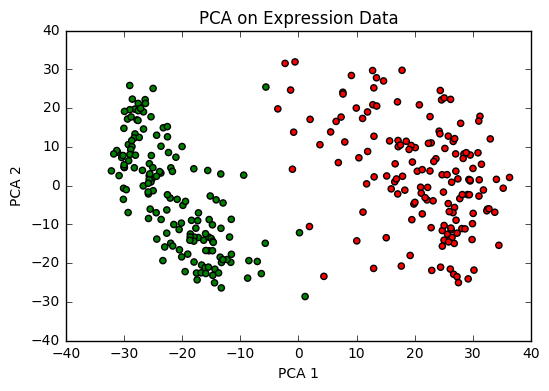

[0 1]


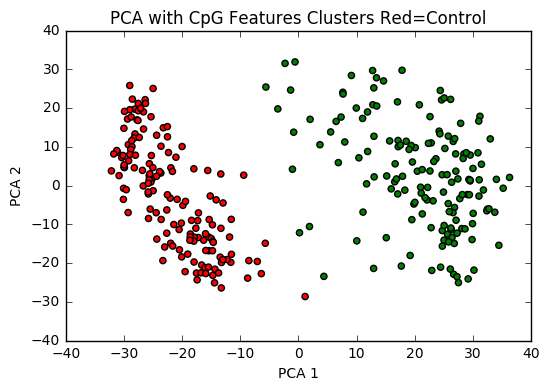

In [94]:
## PCA
methyl_PCA = PCA()
results = methyl_PCA.fit_transform(totalTrainingData)
clusterer = KMeans(n_clusters=2)
cluster_labels = clusterer.fit_predict(results)

colors = {0: "r", 1: "g"}
p = plt.scatter(results[:, 0], results[:, 1], c=[colors[c] for c in cluster_labels])
plt.title("PCA on Expression Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# colors_label = [0] * 190 + [1] * (len(cluster_labels) - 190)
colors_label = [0 if label[0] == 0 else 1 for label in totalTrainingLabelValues]
p1 = plt.scatter(results[:, 0], results[:, 1], c=[colors[c] for c in colors_label])
plt.title("PCA with CpG Features Clusters Red=Control")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [102]:
#### NEural net stuff
model = create_nn_model(totalTrainingDataValues.shape[1])
model.fit(totalTrainingDataValues,totalTrainingLabelValues,batch_size=32,epochs=3)
score = model.evaluate(totalTestDataValues, totalTestLabelValues, batch_size=32)
print("Score: ", score)

# model = create_svm()
# Y_train = totalTrainingLabelValues[:,0]
# Y_test = totalTestLabelValues[:,0]
# model.fit(totalTrainingDataValues,Y_train)
# y_score = model.predict_proba(totalTestDataValues)
# print(model.score(totalTestDataValues,Y_test))

Epoch 1/3
305/305 [==============================] - 3s 9ms/step - loss: 1.7402 - acc: 0.8033
Epoch 2/3
305/305 [==============================] - 2s 6ms/step - loss: 0.0292 - acc: 0.9967
Epoch 3/3
77/77 [==============================] - 0s 1ms/step
Score:  [1.1920928955078125e-07, 1.0]
